In this tutorial, we will cover topics and ways of using ElectroKitty that do not fit into a singular general theme. As such this tutorial will mostly serve as an approximate guide to fiddling around with the package. As such this tutorial will be less cohesive than the first 5 and is more intended for people that are already familiar with basic simulation, data analysis and so on.

The code demonstrated here is probably not the best way to do these things, but it is not our intention for it to be a "best-way-to-program-with-ElectroKitty" kind of tutorial, our intent is more to give you some ideas on how to use ElectroKitty beyond what we have just demonstrated.

# Simulating custom signals

As you might have noticed ElectroKitty by default does not really support simulation using "weird-looking" potential signals. However, we can trick ElectroKitty into simulating more or less any signal we want as long as the time differences in the signal are constant. It is important to stress though that the simulator is not verified for any experiment you might think of, while it can simulate CVs, ACVs and CAs just fine, we have no idea what might happen if you input something weird. Inputting a weird signal is just asking for the simulator to brick, but do not let our warning stop you from experimenting. Who knows you might invent a new voltammetric technique.

Now how do we actually simulate a "weird" signal? Remember that ElectroKitty has a method called set_data, which sets the time and potential of the experiment. Well, it just so happens that ElectroKitty uses only one potential and time array for simulation, plotting, and so on, which this function just so happens to override when called. For the most part, ElectroKitty cares little about where the data comes from, as should be obvious from the 5th tutorial, also nobody said the current needs to make any sense at all. So what we must do is just create the signal that we want to simulate with and pass it to ElectroKitty.

Importing some libraries that will be useful...

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from electrokitty import ElectroKitty

Now we need to create our custom signal. Let us simulate a more advanced form of voltammetry on a surface-confined reaction. First we will scan to some potential, hold there for some time and then scan to our final potential. Essentially it is an interrupted LSV. The easiest way would be for us to construct this signal piece by piece.

Here is the code:

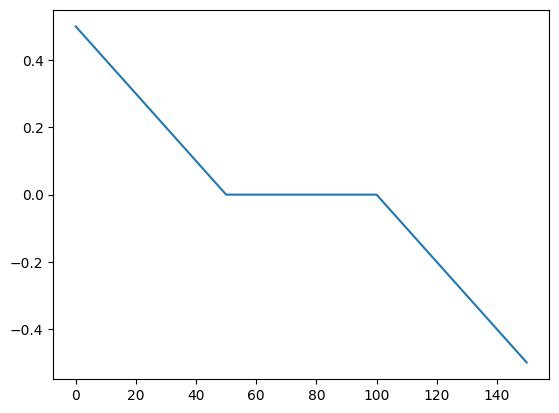

In [13]:
Ei = 0.5
E_hold = 0.0
Ef = -0.5
v = 0.01
dt = 0.1
t_hold = 50

t1 = np.arange(0, (Ei-E_hold)/v, dt)
E1 = Ei - v*t1

t2 = np.arange(0, 50, dt)
E2 = E_hold*np.ones(len(t2))

t3 = np.arange(0, (E_hold - Ef)/v, dt)
E3 = E_hold - v*t3

t = np.append(t1, t2 + t1[-1] + dt)
t = np.append(t, t3 + dt + t[-1])

E = np.append(E1, np.append(E2, E3))

plt.plot(t, E)

The signal we created appears to be what we have wanted. Now let us call ElectroKitty and simulate with the created signal. When calling set_data, we will just pass a bunch of zeros for the current.

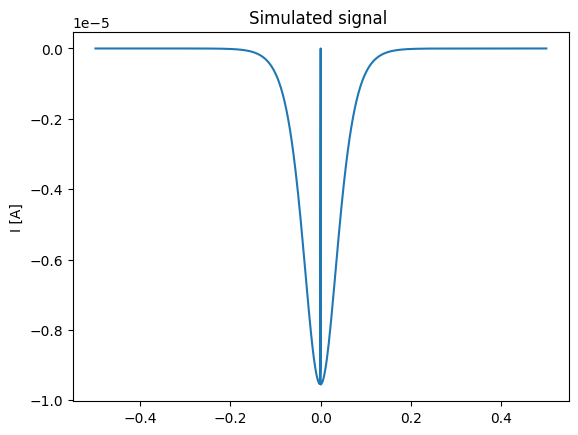

In [15]:
mechanism = "E(1): a*=b*"

kinetic_constants = [[0.5, 100, 0.0]]

diffusion_coef = []

initial_condition = [[10**-5, 0], []]

si = [0.001, 20, 10**-5, 0]

cell_constants = [293, 0 , 0, 10**-4]

isotherm_constants = [0, 0]

simulation = ElectroKitty(mechanism)
simulation.set_data(E, np.zeros(len(E)), t) # Here we call the function and pass it our custom signal
simulation.create_simulation(kinetic_constants, cell_constants, diffusion_coef, isotherm_constants, si, initial_condition)
simulation.simulate()
simulation.Plot_simulation()

The Plot_simulation function seems to have made a not-very-useful plot. Let us plot the current versus time to better see what is going on.

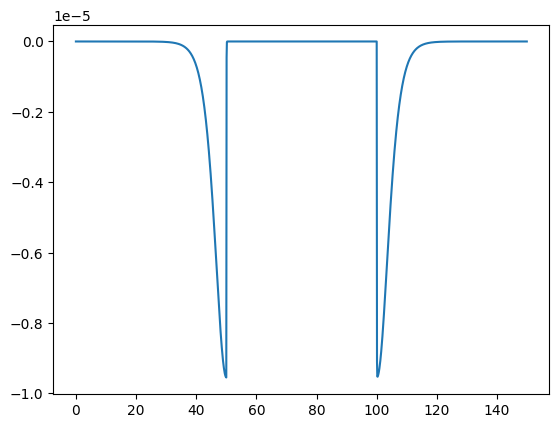

In [16]:
plt.plot(simulation.t, simulation.current)

Looks about what we expected. Now it is up to you to have fun with simulating electrochemical reactions with different potential programs and matching the simulation perfectly with experiments so that you can finally write and publish an article clearly demonstrating the reaction mechanism that has been eluding researchers for decades or you will brick the simulator and the only thing you will write is an angry email addressing me how worthless and incompetent this simulator is. Either way ElectroKitty has the capacity to make it happen.

# Using ElectroKitty in a script

Sometimes we want to simulate our model under different potentiodynamic conditions. A good example of this is EIS, where at a certain potential we probe our system under different frequencies. We could use a different simulator made specifically for impedance studies and it is probably a good idea to do so, it is nonetheless a useful example to show off how to write scripts that incorporate ElectroKitty.

This is just an example of a program that incorporates ElectroKitty into a larger scheme and the program will likely look completely different if you were trying to do anything else.

In [75]:
def calc_one_freq(fr):
    mechanism = "E(1): a*=b*"

    kinetic_constants = [[0.5, 0, 0.0]] # we set the kinetic constant to 0 so that we simulate just the RC circuit
    
    diffusion_coef = []
    
    initial_condition = [[10**-5, 0], []]
    
    si = [0.001, 20, 10**-5, 0]
    
    cell_constants = [293, 200 , 10**-3, 10**-4]
    
    isotherm_constants = [0, 0]

    t = np.linspace(0, 10/fr, 2**10)
    E = 0.01*np.sin(2*np.pi*fr*t)
    
    simulation = ElectroKitty(mechanism)
    simulation.set_data(E, np.zeros(len(E)), t) # Here we call the function and pass it our custom signal
    simulation.create_simulation(kinetic_constants, cell_constants, diffusion_coef, isotherm_constants, si, initial_condition)
    simulation.simulate()

    ft = np.fft.fft(simulation.current, norm = "forward") # doing the FT of our simulation, we set the normalization to forward for convenience
    fte = np.fft.fft(simulation.E_generated, norm = "forward")
    imp = ft/fte
    
    return imp[10].real, imp[10].imag

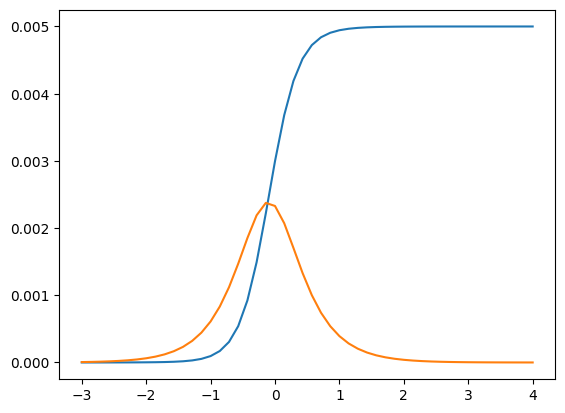

In [78]:
freqs = np.logspace(-3, 4, 50)

x = []
y = []

for freq in freqs:
    res = calc_one_freq(freq)
    x.append(res[0])
    y.append(res[1])
    
# A rough Bode plot of our simulation
plt.plot(np.log10(freqs), x)
plt.plot(np.log10(freqs), y)

Again this is just an example of how we could go about this. We could script ElectroKitty to give us currents for different mechanisms and parameters, to build a learning data set for a ML model, or we could see how a mechanism behaves under different scan rates, and hold potentials. The point being, that there are many different reasons to write a script around a simulator and hopefully, you should not have many difficulties doing that with ElectroKitty. 

# Accessing the different classes of ElectroKitty

This section is less of a tutorial and more of a guideline on what you should be careful about when calling the separate classes.

If for some reason or another, you need access to the inner workings of the library this should be fairly straightforward. The library is made up of classes each doing its part so that ElectroKitty can do your bidding, but can be called individually. There are a couple of caveats with this that you should be mindful of if you go down that road. The classes comprising ElectroKitty were made to be used together as a whole as can be noticed by looking at the code. So when you call a class individually you need to be careful to pass to it the relevant information it needs to execute properly. You should look this up in the documentation. 

Since the class you will be most likely interested in is the simulator class you should be mindful of which one you wish to call, as they do not have the same functions, but they do simulations with the same algorithm. The default simulator is the C++ version, which when ElectroKitty is installed is its own Python package, so be mindful when calling cpp_ekitty_simulator directly. The other is the Python implementation the one you are most likely to be interested in. This is a class where you should experiment with different simulation methods or if you would just like a look into how ElectroKitty works. Also, note with the Python implementation that the base_class never calls it and that is by design. We did not get rid of the Python simulator because: 1. it is used for the development of ElectroKitty, so if you wish to help with the project the Python simulator is a good starting point, and 2. I believe that it can serve as a good pedagogical tool if you would like to go beyond simulating simple reaction mechanisms found in textbooks. Who knows maybe one-day you will make your own simulator... 